# Room Occupancy
Cilj projekta je predvideti zauzetost prostorije na osnovu faktora okoline. 
<br>
Dataset koji se koristi: https://www.kaggle.com/robmarkcole/occupancy-detection-data-set-uci?select=datatest2.txt


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('datatest2.txt')
data.head(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 1 to 9752
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           9752 non-null   object 
 1   Temperature    9752 non-null   float64
 2   Humidity       9752 non-null   float64
 3   Light          9752 non-null   float64
 4   CO2            9752 non-null   float64
 5   HumidityRatio  9752 non-null   float64
 6   Occupancy      9752 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 609.5+ KB


In [4]:
def toOrdinalDate(column):
    arr=[]
    for date in column:
        time=pd.Timestamp(date)
        time=time.toordinal()
        arr.append(time)
    return pd.DataFrame(np.array(arr), index=data.index)
data['date'] = toOrdinalDate(data['date'].to_numpy())

In [5]:
def rescaling(dfColumn):
    feature = dfColumn.to_numpy().reshape(-1, 1)
    minmax_scale = StandardScaler()
    scaled_feature = minmax_scale.fit_transform(feature)
    return pd.Series(scaled_feature.reshape(-1), index=data.index)

for column in data:
    if column != 'Occupancy':
        data[column] = rescaling(data[column])


In [6]:
data.head(5)
data['Occupancy'] = data['Occupancy'].astype('float64')

## Razdvajanje klasne kolone od nezavisnih atributa

In [7]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,0:6]
Y = data.iloc[:,-1]
#print(X)
#print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Funkcija za proveru i prikaz rezultata
Podaci koje je moguce izvuci iz history callback-a su:<br>
['accuracy', 'loss', 'val_accuracy', 'val_loss']

In [8]:
def print_result(model):
    model.evaluate(X_test, Y_test)[1]
    #-----------------------------------------------
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    #------------------------------------------------
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

## Hyperparameters
Definisan je batch_size=32 sto predstavlja broj vsta posle kojih se vrsi podesavanje tezina.
<br>
Broj epoha tj. broj iteracija kroz koje prolaze svi podaci u trening setu je podesen na 30.
<br>
Definisan je ulazni (vidljivi) layer input_dim=6 na osnovu broja nezavisnih atributa (features).
<br>
Broj cvorova u hidden layer-ima podesen je na 16. 

In [9]:
BATCH_SIZE=32
EPOCHS=30
INPUT_DIM=6
NODES1=16
NODES2=16

# Definisanje i treniranje modela

## Loss: binary_crossentropy
Binary cross-entropy je logaritmaska loss funkcija, koristi se kod binarne klasifikacije. Kod skupa podataka sa vise klasa koristi se categorical_crossentropy. Metrika koja se posmatra i koristi u treniranju mreze je preciznost koja se i najcesce koristi.

Epoch 1/30
244/244 [==============================] - 1s 2ms/step - loss: 0.6644 - accuracy: 0.5595 - val_loss: 0.4912 - val_accuracy: 0.7893
Epoch 2/30
244/244 [==============================] - 0s 1ms/step - loss: 0.4477 - accuracy: 0.7953 - val_loss: 0.3738 - val_accuracy: 0.7899
Epoch 3/30
244/244 [==============================] - 0s 1ms/step - loss: 0.3387 - accuracy: 0.7979 - val_loss: 0.2506 - val_accuracy: 0.8960
Epoch 4/30
244/244 [==============================] - 0s 1ms/step - loss: 0.2115 - accuracy: 0.9508 - val_loss: 0.1368 - val_accuracy: 0.9841
Epoch 5/30
244/244 [==============================] - 0s 1ms/step - loss: 0.1152 - accuracy: 0.9881 - val_loss: 0.0885 - val_accuracy: 0.9815
Epoch 6/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0733 - accuracy: 0.9893 - val_loss: 0.0685 - val_accuracy: 0.9836
Epoch 7/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0521 - accuracy: 0.9920 - val_loss: 0.0587 - val_accuracy: 0.9877
Epoch 

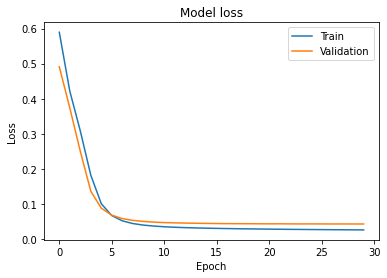

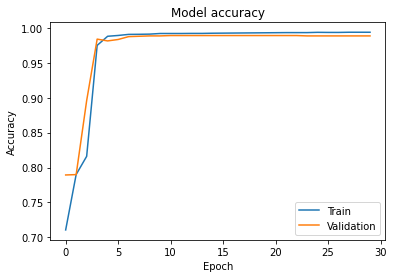

In [10]:
network = Sequential()
network.add(Dense(NODES1, activation="relu", input_dim=INPUT_DIM))
network.add(Dense(NODES2,activation="relu"))
network.add(Dense(1, activation="sigmoid"))

network.compile(optimizer='sgd', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

hist = network.fit(X_train, Y_train, 
                   batch_size=BATCH_SIZE, epochs=EPOCHS, 
                   validation_data=(X_test, Y_test))

#network.summary()

print_result(network)

## Loss: custom_binary_crossentropy

Epoch 1/30
244/244 [==============================] - 1s 2ms/step - loss: 0.6378 - accuracy: 0.6560 - val_loss: 0.2496 - val_accuracy: 0.9580
Epoch 2/30
244/244 [==============================] - 0s 1ms/step - loss: 0.1980 - accuracy: 0.9752 - val_loss: 0.1265 - val_accuracy: 0.9739
Epoch 3/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9844 - val_loss: 0.0873 - val_accuracy: 0.9759
Epoch 4/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0654 - accuracy: 0.9858 - val_loss: 0.0702 - val_accuracy: 0.9805
Epoch 5/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0527 - accuracy: 0.9872 - val_loss: 0.0609 - val_accuracy: 0.9826
Epoch 6/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0441 - accuracy: 0.9879 - val_loss: 0.0553 - val_accuracy: 0.9856
Epoch 7/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0405 - accuracy: 0.9914 - val_loss: 0.0516 - val_accuracy: 0.9877
Epoch 

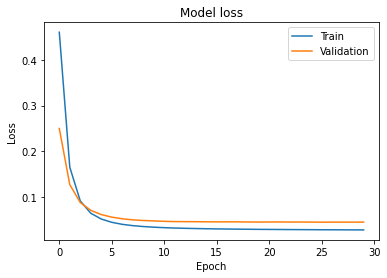

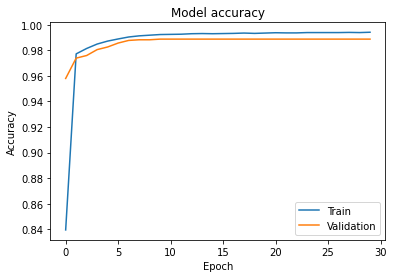

In [11]:
# https://github.com/keras-team/keras/issues/2662?fbclid=IwAR2Xao1cq9FuxcHe0zaE9frK7ISwdALUWilJr4LOVLSuwJ_2nR5HETOds6g
network = Sequential()
network.add(Dense(NODES1, activation="relu", input_dim=INPUT_DIM))
network.add(Dense(NODES2,activation="relu"))
network.add(Dense(1, activation="sigmoid"))

_EPSILON = K.epsilon()
def custom_binary_crossentropy(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float32)
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)

network.compile(optimizer='sgd', 
                loss=custom_binary_crossentropy, 
                metrics=['accuracy'])

hist = network.fit(X_train, Y_train, 
                   batch_size=BATCH_SIZE, epochs=EPOCHS, 
                   validation_data=(X_test, Y_test))

print_result(network)

## Loss: squared_hinge
U situacijama kada je potrebno fino podesavanje modela (tezina). Vece greske su "kaznjene" znacajnije od manjih.

Epoch 1/30
195/195 [==============================] - 1s 2ms/step - loss: 0.4258 - accuracy: 0.8385 - val_loss: 0.0838 - val_accuracy: 0.9827
Epoch 2/30
195/195 [==============================] - 0s 1ms/step - loss: 0.0677 - accuracy: 0.9871 - val_loss: 0.0491 - val_accuracy: 0.9885
Epoch 3/30
195/195 [==============================] - 0s 1ms/step - loss: 0.0469 - accuracy: 0.9888 - val_loss: 0.0369 - val_accuracy: 0.9898
Epoch 4/30
195/195 [==============================] - 0s 1ms/step - loss: 0.0360 - accuracy: 0.9893 - val_loss: 0.0311 - val_accuracy: 0.9898
Epoch 5/30
195/195 [==============================] - 0s 1ms/step - loss: 0.0296 - accuracy: 0.9900 - val_loss: 0.0280 - val_accuracy: 0.9898
Epoch 6/30
195/195 [==============================] - 0s 1ms/step - loss: 0.0260 - accuracy: 0.9904 - val_loss: 0.0261 - val_accuracy: 0.9910
Epoch 7/30
195/195 [==============================] - 0s 1ms/step - loss: 0.0319 - accuracy: 0.9908 - val_loss: 0.0248 - val_accuracy: 0.9910
Epoch 

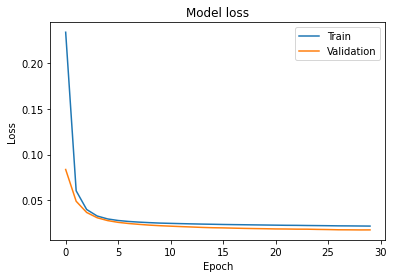

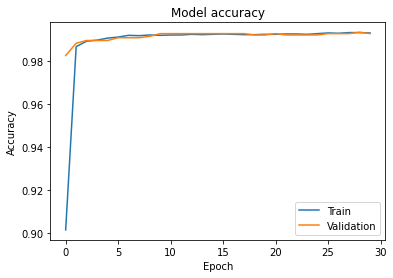

In [12]:
# promena vrednosti klasa {0,1} na {-1,1}
yHinge = Y
yHinge.replace({0: -1})

X_trainH, X_testH, Y_trainH, Y_testH = train_test_split(X, yHinge, test_size=0.2, random_state=1)
X_trainH, X_valH, Y_trainH, Y_valH = train_test_split(X_trainH, Y_trainH, test_size=0.2, random_state=1)

# radi dobro kada je u poslednjem sloju tanh aktivaciona funkcija
classifier2 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='tanh'),])

classifier2.compile(optimizer='sgd',  
                    loss='squared_hinge', 
                    metrics=['accuracy'])

hist = classifier2.fit(X_trainH, Y_trainH, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_valH, Y_valH))

print_result(classifier2)

## Loss: categorical_hinge 

Epoch 1/30
244/244 [==============================] - 1s 1ms/step - loss: 0.5547 - accuracy: 0.7889 - val_loss: 0.4322 - val_accuracy: 0.7893
Epoch 2/30
244/244 [==============================] - 0s 1ms/step - loss: 0.4335 - accuracy: 0.7861 - val_loss: 0.4197 - val_accuracy: 0.7893
Epoch 3/30
244/244 [==============================] - 0s 1ms/step - loss: 0.4083 - accuracy: 0.7909 - val_loss: 0.3305 - val_accuracy: 0.7893
Epoch 4/30
244/244 [==============================] - 0s 1ms/step - loss: 0.2009 - accuracy: 0.8739 - val_loss: 0.0830 - val_accuracy: 0.9841
Epoch 5/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0575 - accuracy: 0.9864 - val_loss: 0.0515 - val_accuracy: 0.9877
Epoch 6/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0368 - accuracy: 0.9907 - val_loss: 0.0407 - val_accuracy: 0.9897
Epoch 7/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.9916 - val_loss: 0.0345 - val_accuracy: 0.9903
Epoch 

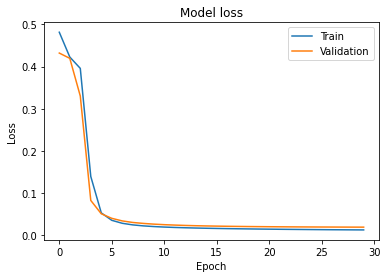

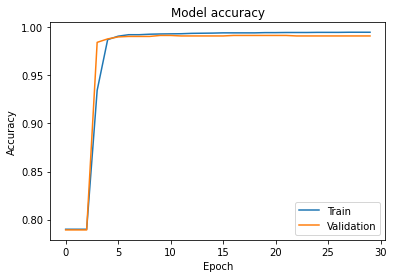

In [13]:
# radi dobro kada je u poslednjem sloju tanh aktivaciona funkcija
classifier3 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='tanh'),])

classifier3.compile(optimizer='sgd',  
                    loss='categorical_hinge', 
                    metrics=['accuracy'])

hist = classifier3.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

print_result(classifier3)

## Loss: custom_mse 1
Modifikovana MSE loss funcija: I ako MSE odgovara regresiji, a ne klasifikaciji u sustini jedina razlika jeste ta da se razlika izmedju stvarne vrednisti i predvidjene deli sa 10. Na taj nacin se dobija da se smanjuje magnituda gubitaka sto moze biti korisno u situacijama kada je MSE velika.

Epoch 1/30
244/244 [==============================] - 1s 1ms/step - loss: 0.0673 - accuracy: 0.6264 - val_loss: 0.0616 - val_accuracy: 0.8498
Epoch 2/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0590 - accuracy: 0.8429 - val_loss: 0.0552 - val_accuracy: 0.8232
Epoch 3/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0528 - accuracy: 0.8157 - val_loss: 0.0501 - val_accuracy: 0.8042
Epoch 4/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0489 - accuracy: 0.8025 - val_loss: 0.0459 - val_accuracy: 0.8145
Epoch 5/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0441 - accuracy: 0.8175 - val_loss: 0.0422 - val_accuracy: 0.8365
Epoch 6/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0411 - accuracy: 0.8267 - val_loss: 0.0388 - val_accuracy: 0.8483
Epoch 7/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0375 - accuracy: 0.8502 - val_loss: 0.0355 - val_accuracy: 0.8729
Epoch 

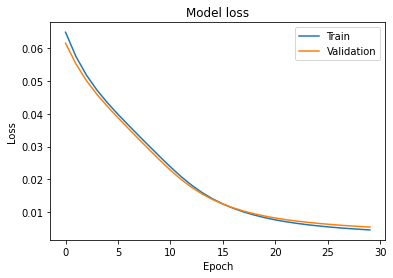

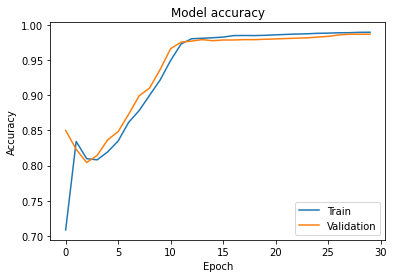

In [14]:
# https://heartbeat.fritz.ai/how-to-create-a-custom-loss-function-in-keras-637bd312e9ab
classifier4 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='sigmoid'),])

def custom_mse1(y_actual, y_pred):
    y_actual = tf.dtypes.cast(y_actual, tf.float32)
    loss = K.mean(K.sum(K.square((y_actual-y_pred)/10.)))
    return loss

classifier4.compile(optimizer='sgd',  
                    loss=custom_mse1, 
                    metrics=['accuracy'])

hist = classifier4.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

print_result(classifier4)

## Loss: custom_mse 2

Epoch 1/30
244/244 [==============================] - 1s 2ms/step - loss: 0.1835 - accuracy: 0.8686 - val_loss: 0.1182 - val_accuracy: 0.8980
Epoch 2/30
244/244 [==============================] - 0s 1ms/step - loss: 0.1069 - accuracy: 0.9061 - val_loss: 0.0813 - val_accuracy: 0.9195
Epoch 3/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0731 - accuracy: 0.9324 - val_loss: 0.0612 - val_accuracy: 0.9323
Epoch 4/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0511 - accuracy: 0.9525 - val_loss: 0.0492 - val_accuracy: 0.9446
Epoch 5/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0435 - accuracy: 0.9565 - val_loss: 0.0412 - val_accuracy: 0.9600
Epoch 6/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0351 - accuracy: 0.9706 - val_loss: 0.0353 - val_accuracy: 0.9662
Epoch 7/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.9751 - val_loss: 0.0308 - val_accuracy: 0.9687
Epoch 

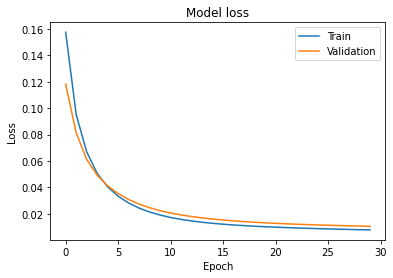

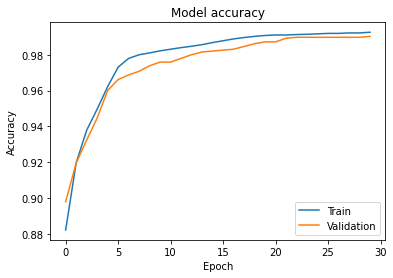

In [15]:
classifier6 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='sigmoid'),])

def custom_mse2(y_actual, y_pred):
    y_actual = tf.dtypes.cast(y_actual, tf.float32)
    loss=K.square(y_pred - y_actual)
    loss=loss*[0.2,0.8]
    return K.sum(loss,axis=1)
    

classifier6.compile(optimizer='sgd',  
                    loss=custom_mse2, 
                    metrics=['accuracy'])

hist = classifier6.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

print_result(classifier6)

##  Loss: Sign penalty
Najpre se proverava da li znak predikcije i stvarne vrednosti razlicit. Ako jeste, to je promasaj znaka i taj slucaj se "kaznjava" tako sto se mnozi sa 10. A ako su predikcija i stvarna vrednost istog znaka, onda nema kaznjavanja. 
<br> 
Vraca srednju vrednost gresaka.

Epoch 1/30
244/244 [==============================] - 1s 2ms/step - loss: 0.2671 - accuracy: 0.4244 - val_loss: 0.1654 - val_accuracy: 0.8344
Epoch 2/30
244/244 [==============================] - 0s 1ms/step - loss: 0.1471 - accuracy: 0.8676 - val_loss: 0.0936 - val_accuracy: 0.9754
Epoch 3/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0825 - accuracy: 0.9841 - val_loss: 0.0554 - val_accuracy: 0.9882
Epoch 4/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0484 - accuracy: 0.9911 - val_loss: 0.0368 - val_accuracy: 0.9882
Epoch 5/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0315 - accuracy: 0.9905 - val_loss: 0.0272 - val_accuracy: 0.9877
Epoch 6/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0224 - accuracy: 0.9929 - val_loss: 0.0219 - val_accuracy: 0.9877
Epoch 7/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0183 - accuracy: 0.9909 - val_loss: 0.0188 - val_accuracy: 0.9877
Epoch 

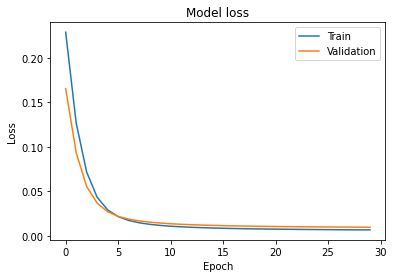

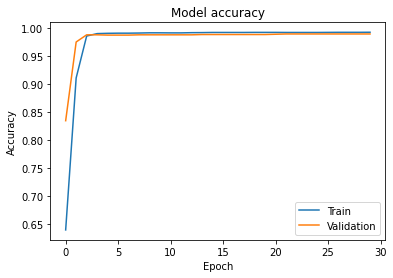

In [16]:
# https://campus.datacamp.com/courses/machine-learning-for-finance-in-python/neural-networks-and-knn?ex=10
# https://projector-video-pdf-converter.datacamp.com/6578/chapter3.pdf

def sign_penalty(y_actual, y_pred):
    y_actual = tf.dtypes.cast(y_actual, tf.float32)
    penalty = 10.
    loss = tf.where(tf.less(y_actual * y_pred, 0), \
                     penalty * tf.square(y_actual - y_pred), \
                     tf.square(y_actual - y_pred))
    return tf.reduce_mean(loss, axis=-1)

classifier5 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='sigmoid'),])

classifier5.compile(optimizer='sgd',  
                    loss=sign_penalty, 
                    metrics=['accuracy'])

hist = classifier5.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

print_result(classifier5)

## Koriscenje adam(Adaptive Moment estimation) optimizatora
Adam algorotam je brzi i zauzima manje memorije od SGD koji je i dalje najkorisceniji. Kreiran je sa idejom da koristi prednosti RMSProp(Root Mean Square Propagation) i AdaGrad(Adaptive Gradient) algoritama.
<br>Dropout sloj se koristi za sprecavanje overfitting-a tako sto zanemaruje pojedine cvorove tokom treniranja.
<br>
### Optimizer: adam & Loss: binary_crossentropy & without Dropout layer

Epoch 1/30
244/244 [==============================] - 1s 2ms/step - loss: 0.4676 - accuracy: 0.8380 - val_loss: 0.0841 - val_accuracy: 0.9759
Epoch 2/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0546 - accuracy: 0.9883 - val_loss: 0.0474 - val_accuracy: 0.9892
Epoch 3/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9910 - val_loss: 0.0432 - val_accuracy: 0.9897
Epoch 4/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0236 - accuracy: 0.9945 - val_loss: 0.0422 - val_accuracy: 0.9903
Epoch 5/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0254 - accuracy: 0.9948 - val_loss: 0.0421 - val_accuracy: 0.9903
Epoch 6/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0236 - accuracy: 0.9947 - val_loss: 0.0418 - val_accuracy: 0.9903
Epoch 7/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0217 - accuracy: 0.9956 - val_loss: 0.0422 - val_accuracy: 0.9903
Epoch 

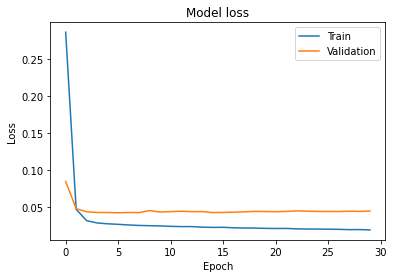

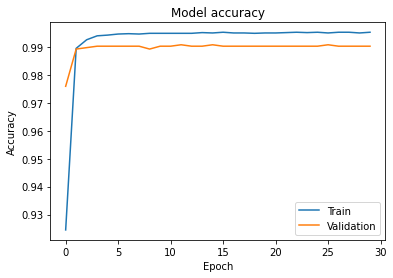

In [17]:
classifier7 = Sequential()
classifier7.add(Dense(NODES1, activation='relu', input_dim=INPUT_DIM))
classifier7.add(Dense(NODES2, activation='relu'))
classifier7.add(Dense(1, activation='sigmoid'))

classifier7.compile(optimizer='adam',  
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

hist = classifier7.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

print_result(classifier7)

### Optimizer: adam & Loss: binary_crossentropy & Dropout layer

Epoch 1/30
244/244 [==============================] - 1s 2ms/step - loss: 0.5296 - accuracy: 0.7848 - val_loss: 0.1571 - val_accuracy: 0.9728
Epoch 2/30
244/244 [==============================] - 0s 1ms/step - loss: 0.1700 - accuracy: 0.9270 - val_loss: 0.0707 - val_accuracy: 0.9805
Epoch 3/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9555 - val_loss: 0.0494 - val_accuracy: 0.9882
Epoch 4/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0688 - accuracy: 0.9623 - val_loss: 0.0452 - val_accuracy: 0.9892
Epoch 5/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0626 - accuracy: 0.9729 - val_loss: 0.0443 - val_accuracy: 0.9892
Epoch 6/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0531 - accuracy: 0.9874 - val_loss: 0.0444 - val_accuracy: 0.9892
Epoch 7/30
244/244 [==============================] - 0s 1ms/step - loss: 0.0550 - accuracy: 0.9857 - val_loss: 0.0442 - val_accuracy: 0.9897
Epoch 

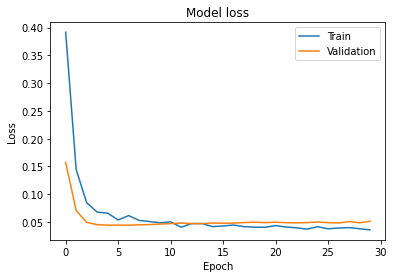

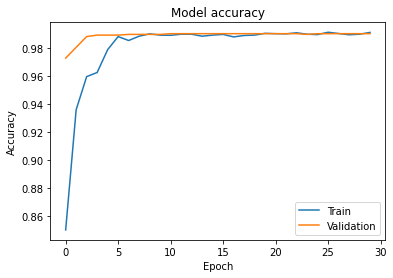

In [18]:
classifier7 = Sequential()
classifier7.add(Dense(NODES1, activation='relu', input_dim=INPUT_DIM))
classifier7.add(Dense(NODES2, activation='relu'))
classifier7.add(layers.Dropout(0.6))
classifier7.add(Dense(1, activation='sigmoid'))

classifier7.compile(optimizer='adam',  
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

hist = classifier7.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

print_result(classifier7)